### **Rationale for Chunk Sizes**

To select appropriate chunk sizes for vector indexing, the character-count distributions of PDF pages and Markdown sections were analyzed using boxplots and histograms.

#### **PDF Files**

PDF pages showed a broad but stable distribution without extreme outliers and generally contained more text in each section.

→ **Chunk size:** **median page character count** (2090), representing a typical PDF page length.

#### **Markdown Files**

Markdown sections exhibited a skewed distribution with several very large outliers.

→ **Chunk size:** **maximum non-outlier value** (upper whisker: Q3 + 1.5×IQR = 1172), representing the upper bound of a typical section before outlier lengths begin.

---

### **Summary**

* **PDF:** median-based chunk size (2090)
* **Markdown:** non-outlier upper bound (1172)

This approach aims to minimize outlier-driven chunk inflation and produce coherent, contextually meaningful chunks for improved retrieval quality.

In [1]:
import pymupdf
from glob import glob
import json
import re
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from pandas import Series

In [2]:
INPUT_FOLDER = "../data/*"
CONFIG_FILE = "../configs/data_config.json"

In [3]:
input_files = glob(INPUT_FOLDER)

In [4]:
with open(CONFIG_FILE) as f:
    data_config = json.load(f)

assert len(input_files) == len(data_config), "Input file missing in config."

In [5]:
WHITESPACE_PATTERN = re.compile(r"\s{2,}")
IMAGE_PATTERN = re.compile(r'!\[[^\]]*\]\([^)\s]+(?:\s+"[^"]*")?\)')
NEWLINE_PATTERN = re.compile(r'\n+')
MD_HEADING_PATTERN = re.compile(r"(?=^#{1,6}\s+)", re.MULTILINE)

In [6]:
def clean_text(text_sections):
    """Clean and normalize text sections efficiently."""
    cleaned = []
    
    for text in text_sections:
        text = text.strip()
        if not text:
            continue
        
        # Filter non-printable characters (faster than string.printable)
        text = ''.join(c for c in text if c.isprintable())
        
        # Apply regex substitutions
        text = WHITESPACE_PATTERN.sub('\n', text)
        text = IMAGE_PATTERN.sub('\n', text)
        text = NEWLINE_PATTERN.sub(' ', text)
        text = text.replace("---", "")
        
        if text:
            cleaned.append(text)
    
    return cleaned

def process_pdf(filepath):
    """Extract and clean text from PDF."""
    doc = pymupdf.Document(filepath)
    text_sections = [page.get_text() for page in doc]
    return clean_text(text_sections)

def process_markdown(filepath):
    """Extract and clean text from Markdown."""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()
    text_sections = MD_HEADING_PATTERN.split(text)
    return clean_text(text_sections)

def visualize_distribution(num_chars, file_type, char_limit=None):
    """Create histogram and boxplot for character distribution."""
    
    # Histogram
    plt.figure(tight_layout=True)
    plt.hist(num_chars, bins=50 if file_type == "pdf" else 100)
    plt.title(f"Distribution of characters in {file_type.upper()} {'page' if file_type == 'pdf' else 'section'}")
    plt.show()
    
    # Boxplot
    plt.figure(tight_layout=True)
    data = [c for c in num_chars if c < char_limit] if char_limit else num_chars
    plt.boxplot(data)
    plt.title(f"Distribution of characters in {file_type.upper()} {'page' if file_type == 'pdf' else 'section'}")
    plt.show()

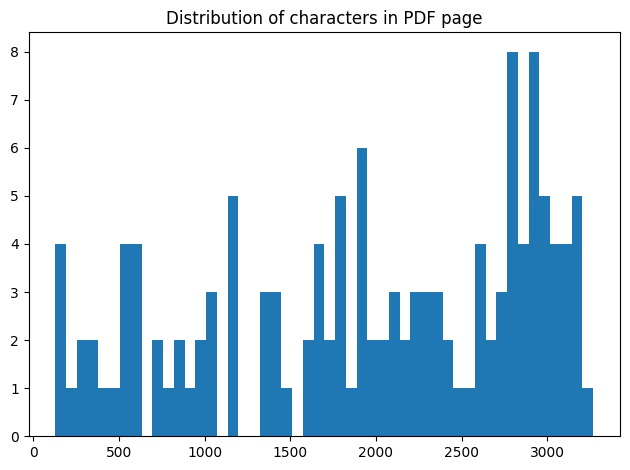

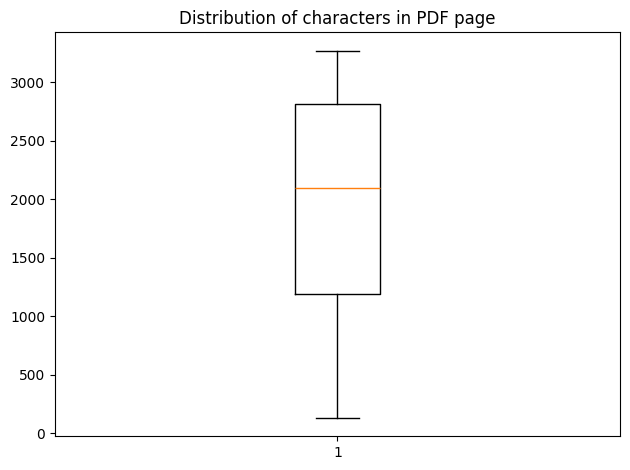

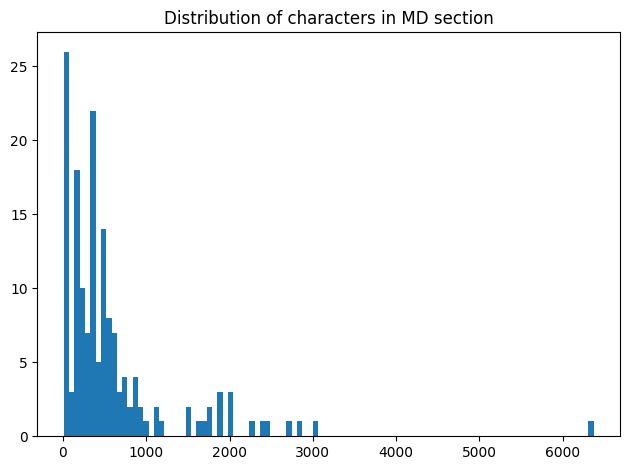

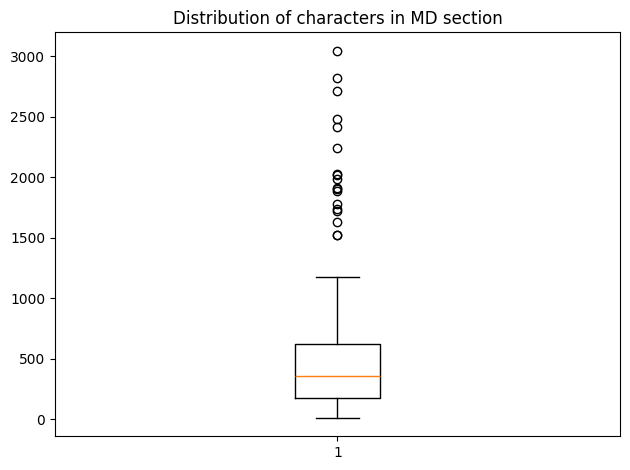

In [7]:
text_documents = {}
num_chars_pdf = []
num_chars_md = []

for file in input_files:
    filepath = Path(file)
    
    if filepath.suffix == '.pdf':
        cleaned_text = process_pdf(file)
        text_documents[file] = cleaned_text
        num_chars_pdf.extend(len(page) for page in cleaned_text)
    
    elif filepath.suffix == '.md':
        cleaned_text = process_markdown(file)
        text_documents[file] = cleaned_text
        num_chars_md.extend(len(page) for page in cleaned_text)

visualize_distribution(num_chars_pdf, "pdf")
visualize_distribution(num_chars_md, "md", char_limit=6000)

In [8]:
max_characters_in_pdf = np.percentile(Series(num_chars_pdf), 50)

num_chars_md = np.array(num_chars_md)
q1 = np.percentile(num_chars_md, 25)
q3 = np.percentile(num_chars_md, 75)
iqr = q3 - q1
upper_whisker = q3 + 1.5 * iqr
max_characters_in_md = num_chars_md[num_chars_md <= upper_whisker].max()

print("Max chunk size in PDF document:", int(max_characters_in_pdf))
print("Max chunk size in MD document:", int(max_characters_in_md))

Max chunk size in PDF document: 2090
Max chunk size in MD document: 1172
